Anggota Kelompok : 
1. Carina Aura Pharamita (Engineering)
2. Mario Catur Noviawan (Engineering)
3. Aditya Reza (OT)
4. Ana Qonitah Munawwaroh (Produksi & IT)

Problem Statement :
Berdasarkan data pada departemen engineering, KWH dipengaruhi oleh nilai press10bar dan flow10bar.

Objective :
Membuat supervised machine learning model dengan Linear Regression
untuk bisa memprediksi nilai target (KW) berdasarkan nilai input (press10bar dan flow10bar)
- Mengetahui Effisiensi KW

Langkah-langkah :
1. Data Preparation
2. Split Data
3. Feature Selection -> Scaling
5. Modelling
6. Tuning
7. Melatih model Linear Regression

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# DATA PREPARATION 
##### Pengumpulan data dari sumber data RealTime GRAFANA

In [250]:
# Masukkan excel data mesin Pres dan mesin Flow
file_path = "data_press_flow.xlsx" 

# Membaca data dari Excel
data_ori_pressflow = pd.read_excel(file_path)
data_ori_pressflow


,date,time,FLOW_10_Bar_Line_1,FLOW_10_Bar_Line_2,Press10bar_ijk1,Press10bar_ijk2,press10bar
0,2024-12-16,12:20:00,65.4351,95.7729,0.00000,9.3,9.5
1,2024-12-16,12:21:00,156.3740,192.6710,0.00000,9.5,9.7
2,2024-12-16,12:22:00,136.9810,170.1640,0.00000,9.4,9.6
3,2024-12-16,12:23:00,65.1416,90.9502,0.00000,9.3,9.5
4,2024-12-16,12:24:00,78.2168,111.1190,0.00000,9.4,9.5
...,...,...,...,...,...,...,...
2848,2024-12-18,12:15:00,214.8450,256.1000,9.26880,9.4,9.6
2849,2024-12-18,12:16:00,253.7770,297.7530,9.21045,9.3,9.6
2850,2024-12-18,12:17:00,202.9450,249.5230,9.13696,9.4,9.6
2851,2024-12-18,12:18:00,194.4240,234.4700,9.16602,9.3,9.6


In [251]:
data_ori_pressflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2853 non-null   datetime64[ns]
 1   time                2853 non-null   object        
 2   FLOW_10_Bar_Line_1  2828 non-null   float64       
 3   FLOW_10_Bar_Line_2  2828 non-null   float64       
 4   Press10bar_ijk1     2853 non-null   float64       
 5   Press10bar_ijk2     2853 non-null   float64       
 6   press10bar          2853 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 156.2+ KB


In [252]:
data_ori_pressflow.head(1000)

,date,time,FLOW_10_Bar_Line_1,FLOW_10_Bar_Line_2,Press10bar_ijk1,Press10bar_ijk2,press10bar
0,2024-12-16,12:20:00,65.43510,95.7729,0.00000,9.3,9.5
1,2024-12-16,12:21:00,156.37400,192.6710,0.00000,9.5,9.7
2,2024-12-16,12:22:00,136.98100,170.1640,0.00000,9.4,9.6
3,2024-12-16,12:23:00,65.14160,90.9502,0.00000,9.3,9.5
4,2024-12-16,12:24:00,78.21680,111.1190,0.00000,9.4,9.5
...,...,...,...,...,...,...,...
995,2024-12-17,05:04:00,7.55176,20.6514,9.33545,9.4,9.5
996,2024-12-17,05:05:00,15.19140,18.7515,9.25708,9.3,9.5
997,2024-12-17,05:06:00,158.57800,225.5550,9.19971,9.4,9.6
998,2024-12-17,05:07:00,124.49400,148.8260,9.19971,9.5,9.6


#### Data Flow diambil dari FLOW_10_Bar_Line_1 + FLOW_10_Bar_Line_2

In [253]:
# Menjadikan Satu Antara 2 Kolom Yang Beda (Tgl Dan Jam)
data_ori_pressflow['DateTime'] = pd.to_datetime(data_ori_pressflow['date'].astype(str) + ' ' + data_ori_pressflow['time'].astype(str))
# Data Flow10bar didapatkan dari 10bar Line1 + Line2
data_ori_pressflow['flow10bar']=data_ori_pressflow['FLOW_10_Bar_Line_1'] + data_ori_pressflow['FLOW_10_Bar_Line_2']
# Mengahapus kolom yang tidak perlu
data_ori_pressflow.drop(['date', 'time', 'Press10bar_ijk1', 'Press10bar_ijk2', 'FLOW_10_Bar_Line_1','FLOW_10_Bar_Line_2'],axis=1,inplace=True)

##### Karena data realtime Flow dan Press tiap 1 menit, maka dirubah menjadi AVG per 5 menit

In [254]:
# Mengubah Kolom Date Time Jadi Index Di Kolom 1
data_ori_pressflow.set_index('DateTime', inplace=True)
# Cara merubah data 1 menit menjadi AVG per 5 menit
pressflow_data = data_ori_pressflow.resample('5T').mean()
pressflow_data

C:\Users\amunawwaroh\AppData\Local\Temp\ipykernel_32688\3491444781.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pressflow_data = data_ori_pressflow.resample('5T').mean()


,press10bar,flow10bar
DateTime,,
2024-12-16 12:20:00,9.56,232.56512
2024-12-16 12:25:00,9.62,286.65452
2024-12-16 12:30:00,9.56,242.17788
2024-12-16 12:35:00,9.60,283.65200
2024-12-16 12:40:00,9.58,240.27054
...,...,...
2024-12-18 11:55:00,9.54,545.41940
2024-12-18 12:00:00,9.54,464.51440
2024-12-18 12:05:00,9.50,334.38580


##### Pengecekan Per Baris data Press dan Flow apakah ada data null ?

In [255]:
# Axis = 1 (pengecekan per baris)
pressflow_null = pressflow_data[pressflow_data.isnull().any(axis=1)]
pressflow_null

,press10bar,flow10bar
DateTime,,
2024-12-17 13:25:00,NaN,NaN


#### Menghapus 1 data NULL dan membuat excel baru "OUTPUT PRESS FLOW"

In [256]:
pressflow_data.dropna(inplace=True)
# Simpan hasil ke file baru
pressflow_data.to_excel("output_pressflow.xlsx", index=True)
pressflow_data

,press10bar,flow10bar
DateTime,,
2024-12-16 12:20:00,9.56,232.56512
2024-12-16 12:25:00,9.62,286.65452
2024-12-16 12:30:00,9.56,242.17788
2024-12-16 12:35:00,9.60,283.65200
2024-12-16 12:40:00,9.58,240.27054
...,...,...
2024-12-18 11:55:00,9.54,545.41940
2024-12-18 12:00:00,9.54,464.51440
2024-12-18 12:05:00,9.50,334.38580


##### Pengambilan Data KWH dari GRAFANA

In [257]:
# Data KWH sudah tiap 5 menit
data_ori_kwh = "kw_10bar.xlsx"
kw_data = pd.read_excel(data_ori_kwh)
kw_data

,Time,I1,I2,I3,ZEUS,KW,KWH
0,2024-12-1612:20:00,86.8347,71.4758,74.5521,1994790,54.6014,1994790
1,2024-12-1612:25:00,197.5270,162.2550,160.9820,1994800,97.8290,1994800
2,2024-12-1612:30:00,196.8360,161.5860,160.3860,1994810,67.9800,1994810
3,2024-12-1612:35:00,199.4940,162.5430,162.0980,1994810,97.1137,1994810
4,2024-12-1612:40:00,85.1367,69.5500,72.5360,1994820,96.7759,1994820
...,...,...,...,...,...,...,...
554,2024-12-1811:55:00,203.1810,165.5120,163.5320,1998250,95.0521,1998250
555,2024-12-1812:00:00,201.2370,163.9650,162.5900,1998250,95.0874,1998250
556,2024-12-1812:05:00,199.8900,164.9210,162.7960,1998260,95.9433,1998260
557,2024-12-1812:10:00,81.8086,67.4012,70.6451,1998270,50.1017,1998270


#### Hasil penghapusan kolom dijadikan excel baru "OUTPUT KW"

In [258]:
# Menghapus kolom yang tidak perlu
kw_data.drop(['I1','I2','I3', 'ZEUS','KWH'], axis=1, inplace=True)

kw_data.to_excel("output_kw.xlsx", index=False)
kw_data

,Time,KW
0,2024-12-1612:20:00,54.6014
1,2024-12-1612:25:00,97.8290
2,2024-12-1612:30:00,67.9800
3,2024-12-1612:35:00,97.1137
4,2024-12-1612:40:00,96.7759
...,...,...
554,2024-12-1811:55:00,95.0521
555,2024-12-1812:00:00,95.0874
556,2024-12-1812:05:00,95.9433
557,2024-12-1812:10:00,50.1017


#### Menggabungkan 2 excel dari data preparation diatas menjadi excel baru "COMBINED DATA"

In [259]:
# Membaca kedua file Excel
df1 = pd.read_excel("output_pressflow.xlsx")
df2 = pd.read_excel("output_kw.xlsx")

df2.drop(['Time'], axis=1, inplace=True)
# Menggabungkan kedua DataFrame secara horizontal (kolomnya digabungkan)
df_combined = pd.concat([df1, df2], axis=1)
# Menghapus baris NaN
df_combined.dropna(subset=['KW'], inplace=True)  
# Menghapus baris dengan nilai 0
df_combined = df_combined[df_combined['KW'] != 0]  

# Menyimpan hasil gabungan ke file Excel baru
df_combined.to_excel("combined_data.xlsx", index=False)

# Menampilkan DataFrame hasil gabungan
df_combined


,DateTime,press10bar,flow10bar,KW
0,2024-12-16 12:20:00,9.56,232.56512,54.6014
1,2024-12-16 12:25:00,9.62,286.65452,97.8290
2,2024-12-16 12:30:00,9.56,242.17788,67.9800
3,2024-12-16 12:35:00,9.60,283.65200,97.1137
4,2024-12-16 12:40:00,9.58,240.27054,96.7759
...,...,...,...,...
554,2024-12-18 10:35:00,9.54,477.30880,95.0521
555,2024-12-18 10:40:00,9.50,466.12700,95.0874
556,2024-12-18 10:45:00,9.56,520.39480,95.9433
557,2024-12-18 10:50:00,9.54,477.87340,50.1017


In [260]:
df_combined.corr()

,DateTime,press10bar,flow10bar,KW
DateTime,1.000000,-0.454501,0.745188,0.285099
press10bar,-0.454501,1.000000,-0.402574,-0.342882
flow10bar,0.745188,-0.402574,1.000000,0.292012
KW,0.285099,-0.342882,0.292012,1.000000


In [261]:
df_combined.describe()

,DateTime,press10bar,flow10bar,KW
count,559,559.000000,559.000000,559.000000
mean,2024-12-17 11:37:18.461538304,9.551550,324.217583,72.582908
min,2024-12-16 12:20:00,9.440000,29.213560,36.827900
25%,2024-12-16 23:57:30,9.520000,196.532970,51.787900
50%,2024-12-17 11:35:00,9.560000,283.606675,60.794400
75%,2024-12-17 23:17:30,9.580000,476.440900,95.343750
max,2024-12-18 10:55:00,9.660000,614.469600,111.922000
std,NaN,0.038557,151.995121,22.028339


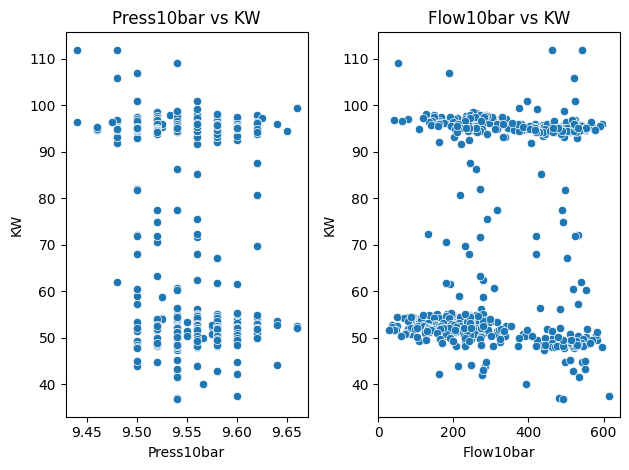

In [262]:
# Scatter plot antara 'press10bar' dan 'KW'
plt.subplot(1, 2, 1)  # Membuat dua plot dalam satu baris
sns.scatterplot(x='press10bar', y='KW', data=df_combined)
plt.title('Press10bar vs KW')
plt.xlabel('Press10bar')
plt.ylabel('KW')

# Scatter plot antara 'flow10bar' dan 'KW'
plt.subplot(1, 2, 2)
sns.scatterplot(x='flow10bar', y='KW', data=df_combined)
plt.title('Flow10bar vs KW')
plt.xlabel('Flow10bar')
plt.ylabel('KW')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [263]:
df_combined.isna().sum()

DateTime      0
press10bar    0
flow10bar     0
KW            0
dtype: int64

## SPLIT DATA

In [264]:
# Feature Engineering

# Memisahkan X dan y = Split between X (Features) and y (target)
X = df_combined[['press10bar', 'flow10bar']]  # Fitur
y = df_combined['KW']  # Target

In [265]:
# Membagi Data = Splitting between Train-Set and Test-set
from sklearn.model_selection import train_test_split

# (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [266]:
X_train.isnull().sum()

press10bar    0
flow10bar     0
dtype: int64

In [267]:
X_test.isnull().sum()

press10bar    0
flow10bar     0
dtype: int64

In [268]:
y_train.isnull().sum()

np.int64(0)

In [269]:
y_test.isnull().sum()

np.int64(0)

## OUTLIER

In [270]:
# Create function to check skewness
def check_skewness(df, *column_names):
    return {col: df[col].skew() for col in column_names if col in df.columns}

In [271]:
skewness_results = check_skewness(X_train, 'press10bar','flow10bar')

# Print skewness
for col, skewness in skewness_results.items():
    print(f"{col}: {skewness}")

press10bar: -0.030568270480464864
flow10bar: 0.05686324493854973


#### Meng-klasifikasikan apakah dia normal/ skew/ extreme skew distribution dgn looping

In [272]:
# Initialize empty lists for each skewness category
normal_columns = []
skewed_columns = []
extreme_skewed_columns = []

# Loop through the skewness values and categorize the columns
for col, skewness in skewness_results.items():
    if skewness < -1.0 or skewness > 1.0:
        extreme_skewed_columns.append(col)
    elif abs(skewness) <= 0.5:
        normal_columns.append(col)
    else:
        skewed_columns.append(col)

# Print the columns in each category
print(f"Normal: {normal_columns}\nSkewed: {skewed_columns}\nExtreme Skewed: {extreme_skewed_columns}")

Normal: ['press10bar', 'flow10bar']
Skewed: []
Extreme Skewed: []


#### Membuat function utk cek persentase outlier, jika <=5% boleh dipertimbangkan utk trim, >5% wajib capping

In [273]:
# Create function to calculate outlier percentages for normal distribution
def calculate_outlier_percentages_normal(df, columns):
    for variable in columns:
        std = df[variable].std()
        lower_boundary = df[variable].quantile(0.25) - (std * 3)
        upper_boundary = df[variable].quantile(0.75) + (std * 3)

        outliers = df[(df[variable] < lower_boundary) | (df[variable] > upper_boundary)]
        outlier_percentage = len(outliers) / len(df) * 100

        print('Percentage of outliers in {}: {:.2f}%'.format(variable, outlier_percentage))

# Calcuate outlier percentages before handling
print(calculate_outlier_percentages_normal(X_train, normal_columns))


Percentage of outliers in press10bar: 0.00%
Percentage of outliers in flow10bar: 0.00%
None


In [274]:
# Create function to calculate outlier percentages for skew
def calculate_outlier_percentages_skew(df, columns, distance):
    for variable in columns:
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

        outliers = df[(df[variable] < lower_boundary) | (df[variable] > upper_boundary)]
        outlier_percentage = len(outliers) / len(df) * 100

        print('Percentage of outliers in {}: {:.2f}%'.format(variable, outlier_percentage))

# Calcuate outlier percentages before handling
print(calculate_outlier_percentages_skew(X_train, skewed_columns, 1.5))
print(calculate_outlier_percentages_skew(X_train, extreme_skewed_columns, 3))

None
None


## Data Bagus Tidak ada Outlier

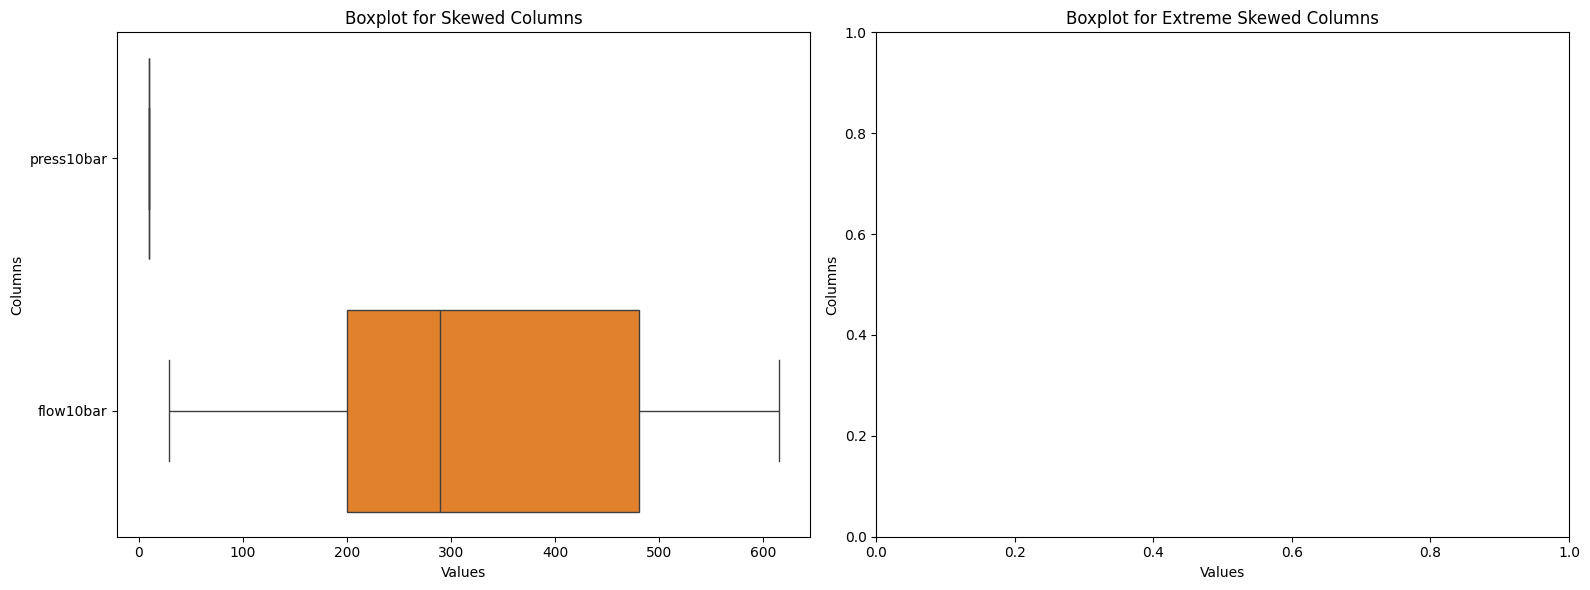

In [275]:
# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for skewed columns
sns.boxplot(data=X_train[normal_columns], orient="h", ax=axes[0])
axes[0].set_title("Boxplot for Skewed Columns")
axes[0].set_xlabel("Values")
axes[0].set_ylabel("Columns")

# Boxplot for extreme skewed columns
sns.boxplot(data=X_train[extreme_skewed_columns], orient="h", ax=axes[1])
axes[1].set_title("Boxplot for Extreme Skewed Columns")
axes[1].set_xlabel("Values")
axes[1].set_ylabel("Columns")

# Display the plot
plt.tight_layout()
plt.show()

## FEATURE SELECTION -> DENGAN SCALING 

In [276]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling pada data training dan testing
X_train_scaled = scaler3.fit_transform(X_train)  # Fit dan transform pada data training
X_test_scaled = scaler3.transform(X_test)  # Hanya transform pada data testing

# Konversi hasil scaling menjadi DataFrame (opsional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['press10bar', 'flow10bar'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['press10bar', 'flow10bar'])

# Tampilkan hasil scaling
print(X_train_scaled_df.head())


   press10bar  flow10bar
0    1.333333  -0.148259
1   -1.000000  -0.258601
2    0.666667  -0.288480
3    0.333333  -0.475036
4    0.333333  -0.432572


### Cek MAE , MSE , R2

In [277]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Inisialisasi model Linear Regression
model = LinearRegression()

# Latih model pada data training yang sudah diskalakan
model.fit(X_train_scaled, y_train)

# Prediksi pada data testing
y_pred = model.predict(X_test_scaled)

# Evaluasi performa model
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Hasil
print("Hasil MAE (Mean Absolute Error) = ",mae) 
print("Hasil MSE (Mean Squared Error) = ",mse) 
print("Hasil r2 (R-squared)= ",r2) 


Hasil MAE (Mean Absolute Error) =  18.28334174130913
Hasil MSE (Mean Squared Error) =  402.8286881988001
Hasil r2 (R-squared)=  0.14828820037874935


In [278]:
# Feature scaling using standard scaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_columns = X_train.select_dtypes(exclude=['object']).columns.tolist() 

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False) # sparse_output(atau sparse aja)=False utk mengganti -> `.toarray()`

preprocess = ColumnTransformer(
    transformers = [
        ('num',scaler,num_columns)],
    remainder='passthrough' # untuk categorical yg sdh di encode
)

## MODELLING

In [279]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import make_pipeline

# Ganti classifier dengan regressor
pipe_log = make_pipeline(LinearRegression())
pipe_rf = make_pipeline(RandomForestRegressor())
pipe_ada = make_pipeline(AdaBoostRegressor())


# HASIL PENGECEKAN MAE, MSE, RSQUARED

In [280]:
# -------MAE-----------
# from sklearn.model_selection import cross_val_score, KFold
# kf = KFold(n_splits=2)
# cv_log_model = cross_val_score(pipe_log, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
# cv_rf_model = cross_val_score(pipe_rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
# cv_ada_model = cross_val_score(pipe_ada, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

# -------R2-----------
from sklearn.model_selection import cross_val_score, KFold
# setting kfold untuk regresi
kf = KFold(n_splits=2)
# Define Cross Validation for each model using R2 scoring
cv_log_model = cross_val_score(pipe_log, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
cv_rf_model = cross_val_score(pipe_rf, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
cv_ada_model = cross_val_score(pipe_ada, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)

# --------MSE---------
# from sklearn.model_selection import cross_val_score, KFold
# kf = KFold(n_splits=2)
# cv_log_model = cross_val_score(pipe_log, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
# cv_rf_model = cross_val_score(pipe_rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
# cv_ada_model = cross_val_score(pipe_ada, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)


In [281]:
print("cv_log_model", cv_log_model)
print("cv_rf_model", cv_rf_model)
print("cv_ada_model", cv_ada_model)

cv_log_model [0.09169816 0.16317899]
cv_rf_model [-0.10422812 -0.02619616]
cv_ada_model [0.08893065 0.1100869 ]


# Model yang bagus menggunakan R-squared
#### Hasil Cross Val Mean from Best Model: 0.12743857575984247
#### Karena nilai rata-rata saat ini cv.mean() lebih besar dari cv_scores


# Model menggunakan MAE dan MSE bernilai 0
#### Karena nilai rata-rata saat ini cv.mean() lebih kecil dari cv_scores

In [282]:
# Finding Best Model based on Cross_Val_Score (mean)
name_model = []
cv_scores = 0
for cv,name in zip([cv_log_model,cv_rf_model,cv_ada_model],
                   ['log_model','rf_model','ada_model']):
  print(name)
  print('f1score - All - Cross Validation :', cv)
  print('f1score - Mean - Cross Validation :', cv.mean())
  print('f1score - std - Cross Validation :', cv.std())
  print('f1score - Range of Test Set :', (cv.mean()-cv.std()), '-' , (cv.mean()+cv.std()))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_scores)

log_model
f1score - All - Cross Validation : [0.09169816 0.16317899]
f1score - Mean - Cross Validation : 0.12743857575984247
f1score - std - Cross Validation : 0.03574041213528206
f1score - Range of Test Set : 0.0916981636245604 - 0.16317898789512453
--------------------------------------------------
rf_model
f1score - All - Cross Validation : [-0.10422812 -0.02619616]
f1score - Mean - Cross Validation : -0.06521214023785404
f1score - std - Cross Validation : 0.039015976791188844
f1score - Range of Test Set : -0.10422811702904289 - -0.0261961634466652
--------------------------------------------------
ada_model
f1score - All - Cross Validation : [0.08893065 0.1100869 ]
f1score - Mean - Cross Validation : 0.09950877172416955
f1score - std - Cross Validation : 0.010578126651835162
f1score - Range of Test Set : 0.08893064507233439 - 0.11008689837600472
--------------------------------------------------
Best Model: log_model
Cross Val Mean from Best Model: 0.12743857575984247


# TUNNING

In [283]:
# Fit pipeline on the training data
pipe_log.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [284]:
# Get predictions for both training and test data
y_pred_train = pipe_log.predict(X_train)
y_pred_test = pipe_log.predict(X_test)

#### Model Evaluation before tuning

In [285]:
y_pred_train

array([56.6758421 , 77.49042761, 61.87948285, 63.68491845, 63.97533647,
       78.50292013, 55.01745739, 63.92594621, 64.53629664, 72.33021769,
       69.44530998, 88.15348197, 75.80590844, 67.89828917, 63.81122268,
       69.6379542 , 78.76465508, 72.09685472, 70.01508701, 69.78544136,
       76.2600866 , 84.88469618, 55.80887186, 86.78607256, 78.99255421,
       86.2632935 , 74.68244618, 75.79306007, 72.25327496, 80.24671704,
       67.60166614, 79.76461336, 84.91321945, 75.30422475, 66.03380878,
       59.72923994, 61.51326735, 85.67832226, 66.119752  , 65.20385434,
       82.29884399, 87.99005817, 69.86339743, 76.26926199, 77.89883678,
       74.44779399, 66.34305966, 86.41636466, 78.10623601, 67.75937649,
       66.65790434, 72.55433488, 77.75802637, 83.92742251, 69.50471214,
       78.70387711, 73.1054153 , 78.92622532, 62.4532313 , 84.86818936,
       78.92888983, 82.9285291 , 84.27036826, 63.37742464, 66.27443544,
       70.74915339, 63.46749872, 88.10096957, 69.86313334, 70.02

In [286]:
y_pred_test

array([62.33978375, 71.56003462, 73.43434701, 66.95188766, 69.76356168,
       81.77496545, 75.92461538, 75.08059315, 83.04242758, 66.87916475,
       66.27378744, 71.94929167, 73.51736717, 65.36095257, 63.85943727,
       70.03990992, 66.58598109, 65.7632418 , 75.33357798, 72.32475876,
       61.05793915, 66.97000391, 69.10259143, 62.57621555, 65.843826  ,
       67.16371745, 69.79457978, 79.4384085 , 73.56475526, 81.512384  ,
       65.7094504 , 87.78096061, 79.97682206, 72.87103117, 78.85961913,
       81.02797489, 73.29414027, 63.28755367, 67.77744398, 72.92737667,
       77.68190918, 67.29438101, 81.6359589 , 70.23382602, 68.88107512,
       67.55634651, 78.1903356 , 66.85358838, 62.10192705, 60.420463  ,
       71.63238226, 78.81182088, 81.65864421, 81.34549149, 82.33146693,
       73.04814797, 78.98091086, 58.1239427 , 66.15978295, 65.86350264,
       87.88457607, 78.09274061, 68.59417519, 75.73555274, 63.30428743,
       80.88527097, 66.40939309, 64.89176705, 72.39319414, 80.98

In [287]:
y_train

182    44.1698
89     58.9095
185    52.2743
148    51.6265
204    52.4744
        ...   
71     97.9230
106    54.6157
270    51.6067
435    95.2123
102    53.9995
Name: KW, Length: 447, dtype: float64

In [288]:
X_train

,press10bar,flow10bar
182,9.64,247.112940
89,9.50,216.089060
185,9.60,207.688254
148,9.58,155.236300
204,9.58,167.175470
...,...,...
71,9.54,243.196400
106,9.62,244.946220
270,9.58,291.938340
435,9.54,457.973800


# Membuat dan melatih model Linear Regression

In [289]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

LinearRegression()

### Mengindikasikan model dapat memprediksi nilai target KW di setiap input data inference yang diberikan

In [290]:
# Data Inference (data baru yang ingin diprediksi)
data_inference = [[9.56, 283.652]]

# Melakukan prediksi menggunakan model yang sudah dilatih
predictions = model_lin_reg.predict(data_inference)

# menampilkan hasil prediksi
print("Hasil Prediksi untuk Data Inference:")
print("NILAI KW = ", predictions)

Hasil Prediksi untuk Data Inference:
NILAI KW =  [69.88992517]


c:\Users\amunawwaroh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
